In [25]:
from sklearn.datasets import load_digits
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
EPS = 1e-10
INF = 1e10

digits = load_digits()
X = torch.from_numpy(digits.data).float()
X = (X - X.mean(dim=0)) / (X.std(dim=0) + EPS)

In [4]:
def pairwise_distance(X):
    square_X = (X ** 2).sum(dim=1)
    pdist = square_X.unsqueeze(1) + square_X.unsqueeze(0) - 2*torch.mm(X, X.T)
    return pdist

def conditional_p(pdist, beta):
    pdist = pdist + torch.eye(len(pdist)) * INF
    exp_dist = torch.exp(-pdist*beta)
    cond_p = exp_dist / (exp_dist.sum(dim=1, keepdims=True) + EPS)
    return cond_p

def calc_perplexity(pdist, beta):
    cond_p = conditional_p(pdist, beta)
    entropy = torch.nansum(-cond_p * torch.log2(cond_p), dim=1)
    perplexity = torch.pow(2, entropy)
    return perplexity

def binary_search_perplexity(pdist, target_perplexity):
    beta_min = torch.ones(len(pdist), 1) * 1e-3
    beta_max = torch.ones(len(pdist), 1) * 100
    
    n_steps = 100
    tolerance = 1e-4
    for i in range(n_steps):
        beta = (beta_min + beta_max) / 2
        perp = calc_perplexity(pdist, beta)
        mask_0 = abs(perp - target_perplexity) <= tolerance
        if torch.all(mask_0):
            break
        mask_1 = perp > target_perplexity + tolerance
        mask_2 = perp < target_perplexity - tolerance
        beta_min[mask_1] = beta[mask_1]
        beta_max[mask_2] = beta[mask_2]
        
    return beta

In [15]:
N = len(X)
pdist = pairwise_distance(X)
beta = binary_search_perplexity(pdist, 50)
cond_p = conditional_p(pdist, beta)
p = (cond_p + cond_p.T) / 2
p = torch.clamp(p / (p.sum() + EPS), min=EPS)

In [16]:
def calculate_q(X_embedded):
    N = len(X_embedded)
    qdist = pairwise_distance(X_embedded)
    qdist = 1 / (qdist + 1)
    mask = torch.ones(N) - torch.eye(N)
    qdist = qdist * mask
    q = torch.clamp(qdist / (qdist.sum() + EPS), min=EPS)
    return q

In [27]:
n_components = 2
X_embedded = nn.Parameter(1e-4 * torch.randn(N, n_components))

early_exaggeration = 12
p = p * early_exaggeration

init_momentum = 0.5
final_momentum = 0.8
lr = max(N / early_exaggeration / 4, 50)
optimizer = torch.optim.SGD([X_embedded], lr=lr, momentum=init_momentum)
n_iter = 1000
early_exploration_iter = 250

In [28]:
for i in range(n_iter):
    if i == early_exploration_iter:
        p = p / early_exaggeration
        optimizer.param_groups[0]['momentum'] = final_momentum
    optimizer.zero_grad()
    q = calculate_q(X_embedded)
    loss = torch.sum(p*torch.log(p/q))
    loss.backward()
    optimizer.step()

In [20]:
emb = X_embedded.detach().numpy()

In [22]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({
    'font.family': 'Arial',
    'font.size': 15.0,
})

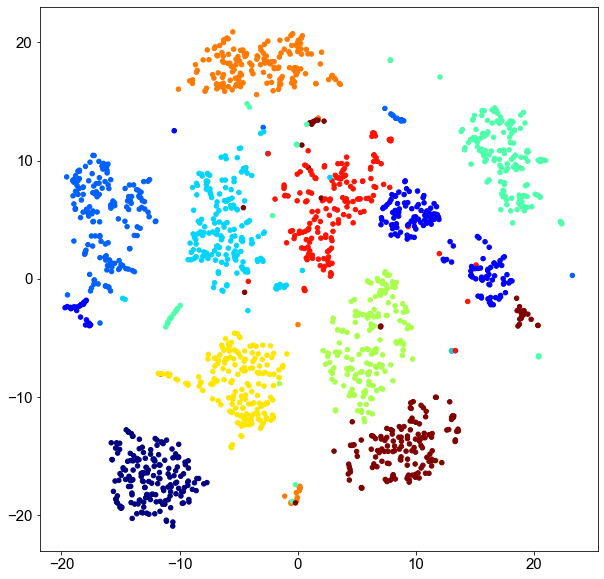

In [23]:
plt.figure(figsize=(10, 10))
plt.scatter(emb[:, 0], emb[:, 1], c=digits.target, cmap='jet', s=20)